# Bert Pratain

In [1]:
import os
os.getcwd()
os.chdir('/home/robb/pytorch')

In [2]:
import math
import re
import collections
import numpy as np
import torch
import torchvision
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import nn
from d2l import torch as d2l
from torch.utils.data import DataLoader, TensorDataset
from model.playDL import *

## DataSet

In [3]:
batch_size, max_len = 512, 64
train_iter, vocab = d2l.load_data_wiki(batch_size, max_len)

In [4]:
net = BERTModel(len(vocab), num_hiddens=128, norm_shape=[128],
                ffn_num_input=128, ffn_num_hiddens=256, num_heads=2,
                num_layers=2, dropout=0.2, key_size=128, query_size=128,
                value_size=128, hid_in_features=128, mlm_in_features=128,
                nsp_in_features=128)

devices = torch.device('cuda')
loss = nn.CrossEntropyLoss()

In [15]:
def _get_batch_loss_bert(net, loss, vocab_size, tokens_X,
                        segments_X, valid_lens_x,
                        pred_positions_X, mlm_weights_X,
                        mlm_Y, nsp_y):
    # 前向传播
    _, mlm_Y_hat, nsp_Y_hat = net(tokens_X, segments_X,
                                valid_lens_x.reshape(-1),
                                pred_positions_X)
    # 计算遮蔽语⾔模型损失
    mlm_l = loss(mlm_Y_hat.reshape(-1, vocab_size), mlm_Y.reshape(-1)) *\
    mlm_weights_X.reshape(-1, 1)
    mlm_l = mlm_l.sum() / (mlm_weights_X.sum() + 1e-8)
    # 计算下⼀句⼦预测任务的损失
    nsp_l = loss(nsp_Y_hat, nsp_y)
    l = mlm_l + nsp_l
    return mlm_l, nsp_l, l

In [16]:
for tokens_X, segments_X, valid_lens_x, pred_positions_X,\
        mlm_weights_X, mlm_Y, nsp_y in train_iter:
    print(segments_X)
    
    break

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])


In [22]:
devices = torch.device('cuda')

In [32]:
def train_bert(train_iter, net, loss, vocab_size, devices, num_steps):
    #net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    net.to(devices)
    trainer = torch.optim.Adam(net.parameters(), lr=0.01)
    
    step, timer = 0, d2l.Timer()
    animator = d2l.Animator(xlabel='step', ylabel='loss',
    xlim=[1, num_steps], legend=['mlm', 'nsp'])
    # 遮蔽语⾔模型损失的和，下⼀句预测任务损失的和，句⼦对的数量，计数
    metric = d2l.Accumulator(4)
    num_steps_reached = False
    while step < num_steps and not num_steps_reached:
        for tokens_X, segments_X, valid_lens_x, pred_positions_X,\
            mlm_weights_X, mlm_Y, nsp_y in train_iter:
            tokens_X = tokens_X.to(devices)
            segments_X = segments_X.to(devices)
            valid_lens_x = valid_lens_x.to(devices)
            pred_positions_X = pred_positions_X.to(devices)
            mlm_weights_X = mlm_weights_X.to(devices)
            mlm_Y, nsp_y = mlm_Y.to(devices), nsp_y.to(devices)
            trainer.zero_grad()
            timer.start()
            
            mlm_l, nsp_l, l = _get_batch_loss_bert(
                    net, loss, vocab_size, tokens_X, segments_X, valid_lens_x,
                    pred_positions_X, mlm_weights_X, mlm_Y, nsp_y)
            
            l.backward()
            trainer.step()
            metric.add(mlm_l, nsp_l, tokens_X.shape[0], 1)
            timer.stop()
            animator.add(step + 1,
                    (metric[0] / metric[3], metric[1] / metric[3]))
            step += 1
            if step == num_steps:
                num_steps_reached = True
                break
    print(f'MLM loss {metric[0] / metric[3]:.3f}, '
        f'NSP loss {metric[1] / metric[3]:.3f}')
    print(f'{metric[2] / timer.sum():.1f} sentence pairs/sec on '
        f'{str(devices)}')

MLM loss 5.449, NSP loss 0.751
7370.6 sentence pairs/sec on cuda


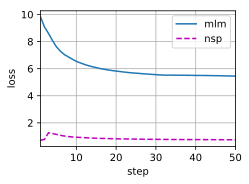

In [33]:
train_bert(train_iter, net, loss, len(vocab), devices, 50)